Import required libraries

In [1]:
import numpy as np, pandas as pd, os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS, ExhaustiveFeatureSelector as EFS
import matplotlib.pyplot as plt
import statsmodels.api as sm

Read the data and show the despcription

In [2]:
data = pd.read_csv(os.path.abspath('gavote.csv'))
data.drop(columns=data.columns[0], inplace=True)  # Drop the first unnamed column
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   equip    159 non-null    object 
 1   econ     159 non-null    object 
 2   perAA    159 non-null    float64
 3   rural    159 non-null    object 
 4   atlanta  159 non-null    object 
 5   gore     159 non-null    int64  
 6   bush     159 non-null    int64  
 7   other    159 non-null    int64  
 8   votes    159 non-null    int64  
 9   ballots  159 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 12.6+ KB
None


,equip,econ,perAA,rural,atlanta,gore,bush,other,votes,ballots
0,LEVER,poor,0.182,rural,notAtlanta,2093,3940,66,6099,6617
1,LEVER,poor,0.230,rural,notAtlanta,821,1228,22,2071,2149
2,LEVER,poor,0.131,rural,notAtlanta,956,2010,29,2995,3347
3,OS-CC,poor,0.476,rural,notAtlanta,893,615,11,1519,1607
4,LEVER,middle,0.359,rural,notAtlanta,5893,6041,192,12126,12785


Plot pie chart and bar chart of the counts of equipments

equip
LEVER    74
OS-CC    44
OS-PC    22
PUNCH    17
PAPER     2
Name: count, dtype: int64


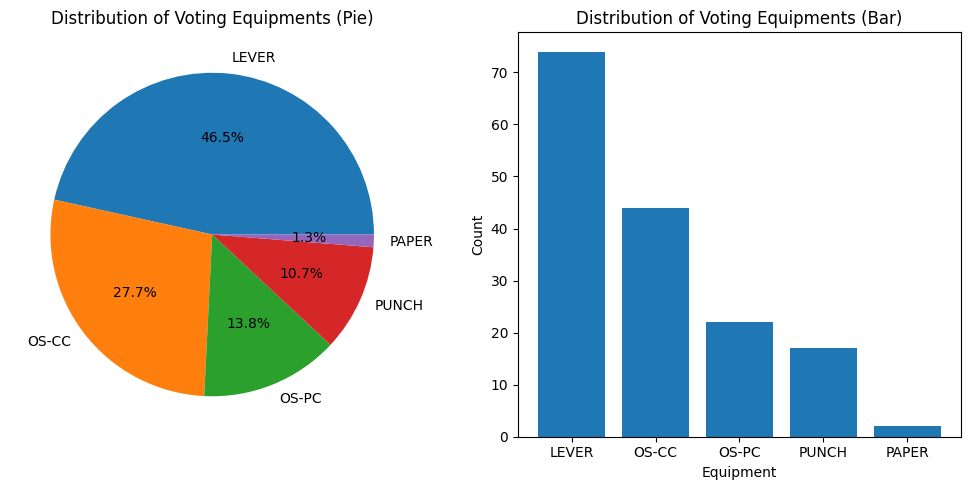

In [3]:
equipment_counts = data['equip'].value_counts()
print(equipment_counts)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Pie chart
ax[0].pie(equipment_counts, labels=equipment_counts.index, autopct='%1.1f%%')
ax[0].set_title('Distribution of Voting Equipments (Pie)')

# Bar chart
ax[1].bar(equipment_counts.index, equipment_counts.values)
ax[1].set_title('Distribution of Voting Equipments (Bar)')
ax[1].set_xlabel('Equipment')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Find the undercounts and normalized under count

In [4]:
under_counts = data['ballots']-data['votes']
data['under_count'] = under_counts
normalized_under_counts = under_counts / data['ballots']
data['normalized_under_count'] = normalized_under_counts

Barplot

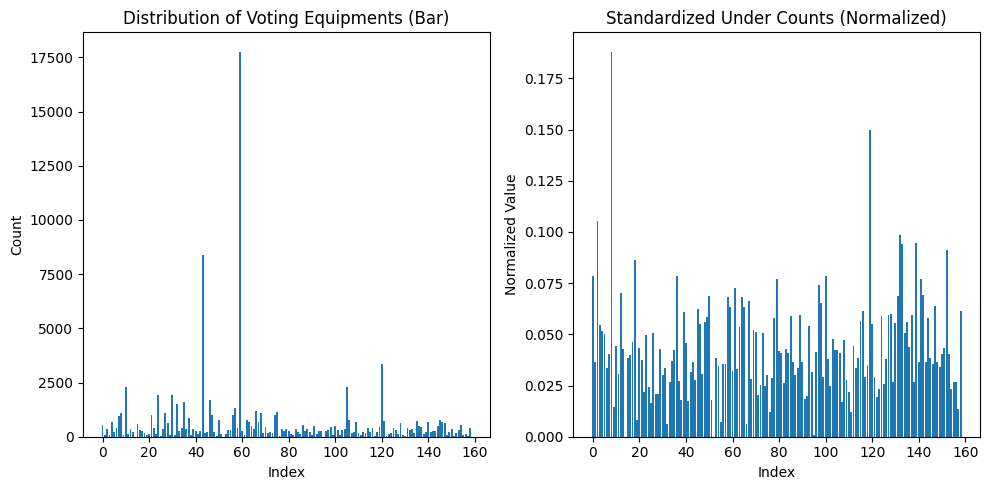

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Bar chart
ax[0].bar(under_counts.index, under_counts.values)
ax[0].set_title('Distribution of Voting Equipments (Bar)')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Count')

# Bar chart
ax[1].bar(normalized_under_counts.index, normalized_under_counts.values)
ax[1].set_title('Standardized Under Counts (Normalized)')
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Normalized Value')

plt.tight_layout()
plt.show()

Histogram

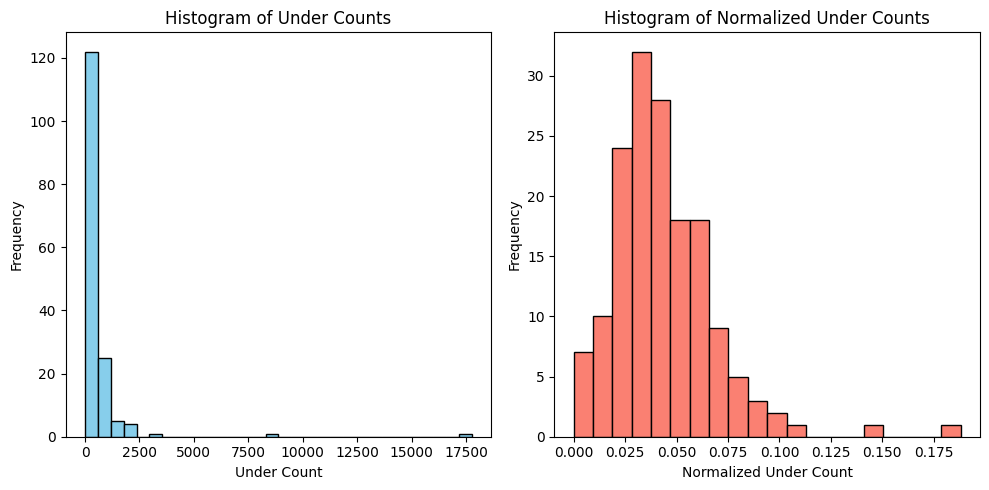

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Histogram for under_counts
ax[0].hist(under_counts.values, bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Histogram of Under Counts')
ax[0].set_xlabel('Under Count')
ax[0].set_ylabel('Frequency')

# Histogram for normalized_under_counts
ax[1].hist(normalized_under_counts.values, bins=20, color='salmon', edgecolor='black')
ax[1].set_title('Histogram of Normalized Under Counts')
ax[1].set_xlabel('Normalized Under Count')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Boxplot

<Figure size 800x800 with 0 Axes>

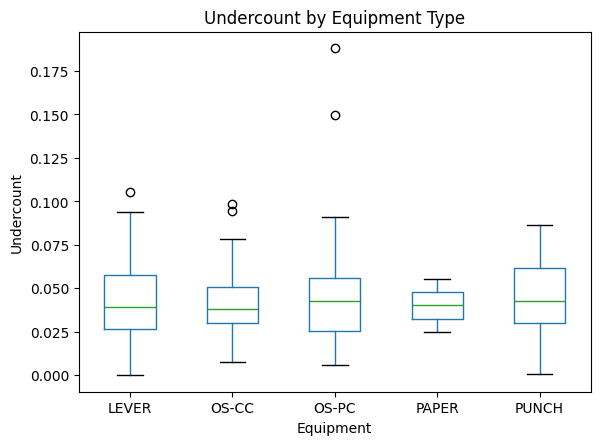

In [7]:
plt.figure(figsize=(8, 8))
data.boxplot(column='normalized_under_count', by='equip', grid=False)
plt.title('Undercount by Equipment Type')
plt.suptitle('')
plt.xlabel('Equipment')
plt.ylabel('Undercount')
plt.show()

Do linear regression

In [8]:
from statsmodels.formula.api import ols

# Use a formula to include categorical variables automatically
model = ols('votes ~ C(equip) + C(econ) + perAA + C(rural) + C(atlanta) + gore + bush + other + ballots', data=data).fit()
model1 = ols('normalized_under_count ~ C(equip) + C(econ) + perAA + C(rural) + C(atlanta) + gore + bush + other + votes + ballots', data=data).fit()
model2 = ols('normalized_under_count ~ C(equip)', data=data).fit()

# print(model.summary())
# print(model1.summary())
# print(model2.summary())

In [9]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare the design matrix for model2 (only 'equip' as categorical variable)
# X is already defined in previous cells, but we need to ensure its dtype is float for OLS
# Prepare X for model2: only 'equip' as categorical variable, with intercept
X = pd.get_dummies(data['equip'], prefix='equip', drop_first=True)
X = sm.add_constant(X)
X = X.astype(float)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Define y and model_fs before forward selection
y = data['normalized_under_count']
model_fs = sm.OLS(y, X).fit()

# Forward selection for features based on p-values
selected_features = ['const']
remaining_features = list(X.columns)
remaining_features.remove('const')
current_score = float('inf')
best_new_score = model_fs.aic

while remaining_features and best_new_score < current_score:
    scores_with_candidates = []
    for candidate in remaining_features:
        features_to_test = selected_features + [candidate]
        model = sm.OLS(y, X[features_to_test]).fit()
        scores_with_candidates.append((model.aic, candidate))
    scores_with_candidates.sort()
    best_new_score, best_candidate = scores_with_candidates[0]
    if best_new_score < current_score:
        selected_features.append(best_candidate)
        remaining_features.remove(best_candidate)
        current_score = best_new_score

print("Selected features by forward selection:", selected_features)
print(vif_data)
# Alternatively, use backward elimination based on p-values
print(model_fs.summary())

Selected features by forward selection: ['const', 'equip_OS-PC']
       feature       VIF
0        const  2.148649
1  equip_OS-CC  1.153323
2  equip_OS-PC  1.117797
3  equip_PAPER  1.014108
4  equip_PUNCH  1.098249
                              OLS Regression Results                              
Dep. Variable:     normalized_under_count   R-squared:                       0.020
Model:                                OLS   Adj. R-squared:                 -0.006
Method:                     Least Squares   F-statistic:                    0.7776
Date:                    Wed, 16 Jul 2025   Prob (F-statistic):              0.541
Time:                            11:53:33   Log-Likelihood:                 363.23
No. Observations:                     159   AIC:                            -716.5
Df Residuals:                         154   BIC:                            -701.1
Df Model:                               4                                         
Covariance Type:                nonrob

Redo

In [10]:
# Convert object columns to categorical dtype and then to codes
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].astype('category').cat.codes
data.dtypes

equip                        int8
econ                         int8
perAA                     float64
rural                        int8
atlanta                      int8
gore                        int64
bush                        int64
other                       int64
votes                       int64
ballots                     int64
under_count                 int64
normalized_under_count    float64
dtype: object

In [11]:
vif = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
pd.DataFrame({'VIF': vif}, index=data.columns)

C:\Users\DS-31\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF
equip,2.140812
econ,2.436732
perAA,4.326084
rural,1.926697
atlanta,5.696519
gore,inf
bush,inf
other,inf
votes,inf
ballots,inf


Data spliting

In [12]:
train,test=train_test_split(data, test_size=0.2, random_state=42)
x_train = train.drop(columns=['under_count','normalized_under_count','other','gore','bush','votes','ballots'])
x_test = test.drop(columns=['under_count','normalized_under_count','other','gore','bush', 'votes', 'ballots'])
y_train = train['normalized_under_count']
y_test = test['normalized_under_count']

print(x_train.columns)
print(y_train.name)

Index(['equip', 'econ', 'perAA', 'rural', 'atlanta'], dtype='object')
normalized_under_count


Function definition

In [13]:
def subset_selection(method, x, y):  # subset selection algorithm
    if method == 'exhaustive':
        selector = EFS(LinearRegression(),
                       min_features=1,
                       max_features=6,
                       scoring='r2',
                       cv=5, n_jobs=-1, print_progress=True)
    elif method == 'forward':
        selector = SFS(LinearRegression(),
                       k_features='best', forward=True, cv=5,
                       scoring='r2')
    elif method == 'backward':
        selector = SFS(LinearRegression(),
                       k_features='best', forward=False, cv=5,
                       scoring='r2')
    return selector.fit(x.values, y.values).subsets_

def feature(method):
    subsets = subset_selection(method, x_train, y_train)
    subsets = pd.DataFrame(subsets).T
    model_id = subsets['avg_score'].idxmax().item()
    feature_names = x_train.columns[list(subsets.loc[model_id, 'feature_idx'])]
    return feature_names

Fit the best subset and return the necessary results

In [14]:
models = {}

def func(method, label, x_train, y_train, x_test, y_test):
    feature_cols = feature(method)
    x_train_subset = x_train[feature_cols]
    x_test_subset = x_test[feature_cols]

    # Add constant (intercept) term
    x_train_const = sm.add_constant(x_train_subset)
    x_test_const = sm.add_constant(x_test_subset)

    model = sm.OLS(y_train, x_train_const).fit()
    models[label] = model

    # Predictions
    y_train_pred = model.predict(x_train_const)
    y_test_pred = model.predict(x_test_const)

    # MSE
    train_mse = np.mean((y_train - y_train_pred)**2)
    test_mse = np.mean((y_test - y_test_pred)**2)

    # R-squared
    train_r2 = model.rsquared
    # test_r2 = 1 - np.sum((y_test - y_test_pred)**2) / np.sum((y_test - np.mean(y_test))**2)

    return {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        # 'test_r2': test_r2,
        'intercept': np.round(model.params[0], 3),
        'coefficients': np.round(model.params[1:].values, 3),
        'model_number': len(feature_cols),
        'feature_names': feature_cols
    }


In [15]:
result_dict = {}
naming = [("forward", "Forward"), ("backward", "Backward")]
for method, label in naming:
    result_dict[method] = func(method, label, x_train, y_train, x_test, y_test)
result = pd.DataFrame(result_dict)

C:\Users\DS-31\AppData\Local\Temp\ipykernel_10380\18098111.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'intercept': np.round(model.params[0], 3),
C:\Users\DS-31\AppData\Local\Temp\ipykernel_10380\18098111.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'intercept': np.round(model.params[0], 3),


In [16]:
print("Forward selection model\n",models['Forward'].summary())

Forward selection model
                               OLS Regression Results                              
Dep. Variable:     normalized_under_count   R-squared:                       0.163
Model:                                OLS   Adj. R-squared:                  0.135
Method:                     Least Squares   F-statistic:                     5.920
Date:                    Wed, 16 Jul 2025   Prob (F-statistic):           0.000218
Time:                            11:53:33   Log-Likelihood:                 297.50
No. Observations:                     127   AIC:                            -585.0
Df Residuals:                         122   BIC:                            -570.8
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [17]:
print(result.forward)

train_mse                                                 0.000541
test_mse                                                   0.00044
train_r2                                                  0.162554
intercept                                                    0.028
coefficients                         [0.005, 0.026, -0.016, 0.011]
model_number                                                     4
feature_names    Index(['equip', 'perAA', 'rural', 'atlanta'], ...
Name: forward, dtype: object


In [18]:
print("Backward selection model\n",models['Backward'].summary())

Backward selection model
                               OLS Regression Results                              
Dep. Variable:     normalized_under_count   R-squared:                       0.163
Model:                                OLS   Adj. R-squared:                  0.135
Method:                     Least Squares   F-statistic:                     5.920
Date:                    Wed, 16 Jul 2025   Prob (F-statistic):           0.000218
Time:                            11:53:33   Log-Likelihood:                 297.50
No. Observations:                     127   AIC:                            -585.0
Df Residuals:                         122   BIC:                            -570.8
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [19]:
print(result.backward)

train_mse                                                 0.000541
test_mse                                                   0.00044
train_r2                                                  0.162554
intercept                                                    0.028
coefficients                         [0.005, 0.026, -0.016, 0.011]
model_number                                                     4
feature_names    Index(['equip', 'perAA', 'rural', 'atlanta'], ...
Name: backward, dtype: object
